# Выбор локации для скважины

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Задачи проекта
Необходимо создать модели машинного обучения и функции для расчёта прибыли и вероятности убытков. С помощью этих инструментов нужно выбрать наиболее перспективный регион для разработки и обосновать свой выбор.

## Загрузка и подготовка данных

### Импорт модулей и библиотек

In [1]:
# Файлы и директории
import os 

# Датафреймы
import pandas as pd

# Математика
import numpy as np
from random import randint

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# ML-модели
from sklearn.linear_model import LinearRegression

# ML-методы
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# ML-метрики
from sklearn.metrics import mean_squared_error

# Настройки
pd.options.mode.chained_assignment = None

# Константы
RND_NUM = 12345
RND_ST = np.random.RandomState(RND_NUM)

### Бизнес-константы

In [2]:
# Количество точек, исследуемых при разведке
POINTS = 500

# Количество лучших точек для машинного обучения
ML_POINTS = 200

# Бюджет на разработку (10 млрд рублей)
BUDGET = 10e9

# Доход с каждой единицы продукта (450 тыс. рублей)
BARREL_PRICE = 450e3

# Порог вероятности убытков (2,5%)
THRESHOLD = 0.025

### Загрузка данных

In [3]:
paths_1 = ['datasets/geo_data_0.csv',
           'datasets/geo_data_1.csv',
           'datasets/geo_data_2.csv']
paths_2 = ['geo_data_0.csv',
           'geo_data_1.csv',
           'geo_data_2.csv']
data=[]

for path_1, path_2  in zip(paths_1, paths_2):
    if os.path.exists(path_1):
        data.append(pd.read_csv(path_1))
    elif os.path.exists(path_2):
        data.apend(pd.read_csv(path_2))
    else:
        print('Something is wrong')

In [4]:
df_1 = data[0]
df_1.info()
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_2 = data[1]
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_3 = data[2]
df_3.info()
df_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


--- 

В каждом из 3-х датасетов содержится 100000 ненулевых объектов с 5-ю признаками:
* `id` — уникальный идентификатор скважины
* `f0, f1, f2` — три признака точек
* `product` — объём запасов в скважине (тыс. баррелей).

### Провекра на наличие дубликатов

In [7]:
print("Дубликатов в df_1:", df_1.duplicated().sum())
print("Дубликатов в df_2:", df_2.duplicated().sum())
print("Дубликатов в df_3:", df_3.duplicated().sum())

Дубликатов в df_1: 0
Дубликатов в df_2: 0
Дубликатов в df_3: 0


Дубликаты в данных отсутствуют.

### Поиск неявных дубликатов
Проверим, нет ли в данных записей для одних и тех же скважин:

In [8]:
print("Идентичных id в df_1:", df_1['id'].duplicated().sum())
print("Идентичных id в df_2:", df_2['id'].duplicated().sum())
print("Идентичных id в df_3:", df_3['id'].duplicated().sum())

Идентичных id в df_1: 10
Идентичных id в df_2: 4
Идентичных id в df_3: 4


На примере первого набора данных, рассмотрим, какие именно значения находятся дубликатах, чтобы понять, какие из них стоит сохранить, а какие отбросить.

Сформируем датафрейм, в котором будут собраны и отсортированы значения с повторяющимся `id`:

In [9]:
duplicates_mask = df_1['id'].duplicated(keep=False)
duplicates_df = df_1[duplicates_mask].sort_values('id')
duplicates_df.head(6)

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504


Так как задача направлена на прогнозирование потенциальной прибыли и вероятности убытков, логично будет оставить строки, в которых более пессимистичные данные. То есть те, где значение `product` меньше.

In [10]:
df_1 = df_1.sort_values('product')
df_1 = df_1.drop_duplicates('id', keep='first')

Проверим на примере `id` = 74z30, какое из двух значений осталось:

In [11]:
df_1[df_1['id'] == '74z30']

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327


В датафрейме осталось строка с меньшим значением `product`, следовательно, аналогичное преобразование можно применить и к оставшимся датафреймам:

In [12]:
df_2 = df_2.sort_values('product')
df_2 = df_2.drop_duplicates('id', keep='first')

df_3 = df_3.sort_values('product')
df_3 = df_3.drop_duplicates('id', keep='first')

# Финальная проверка
print("Идентичных id в df_1:", df_1['id'].duplicated().sum())
print("Идентичных id в df_2:", df_2['id'].duplicated().sum())
print("Идентичных id в df_3:", df_3['id'].duplicated().sum())

Идентичных id в df_1: 0
Идентичных id в df_2: 0
Идентичных id в df_3: 0


### Проверка корреляций в данных

In [13]:
num_columns = ['f0', 'f1', 'f2', 'product'] 

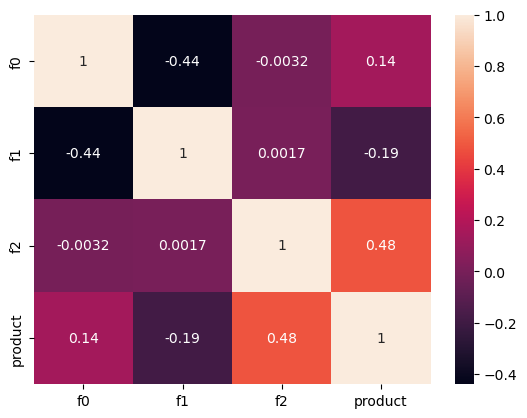

In [14]:
sns.heatmap(df_1[num_columns].corr(), annot=True);

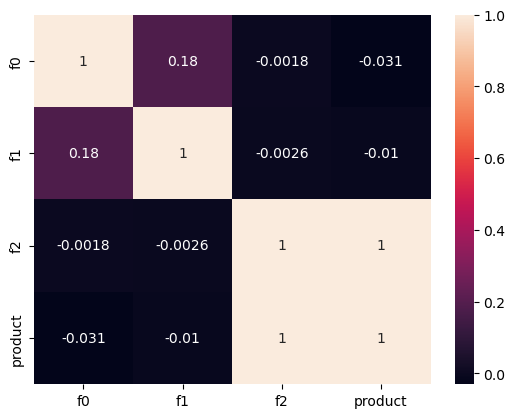

In [15]:
sns.heatmap(df_2[num_columns].corr(), annot=True);

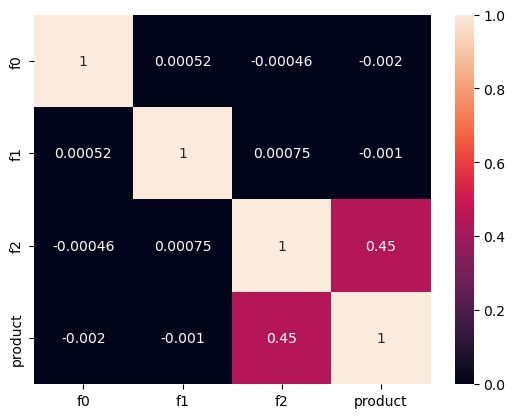

In [16]:
sns.heatmap(df_3[num_columns].corr(), annot=True);

**Наблюдения**

Корреляция наблюдается между признаками `product` и `f2`, что говорит о существенной линейной связи. Во втором датафрейме она самая значительная и равна 1. В 1-м и 3-м находится в пределах 0,45-0,48.

### Анализ распределений и статистик

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500426,0.250151,2.502544,92.497431
std,0.871854,0.504431,3.248126,44.289177
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072653,-0.200864,0.287784,56.495873
50%,0.502360,0.250252,2.515969,91.842960
75%,1.073626,0.700654,4.714970,128.562225
max,2.362331,1.343769,16.003790,185.364347


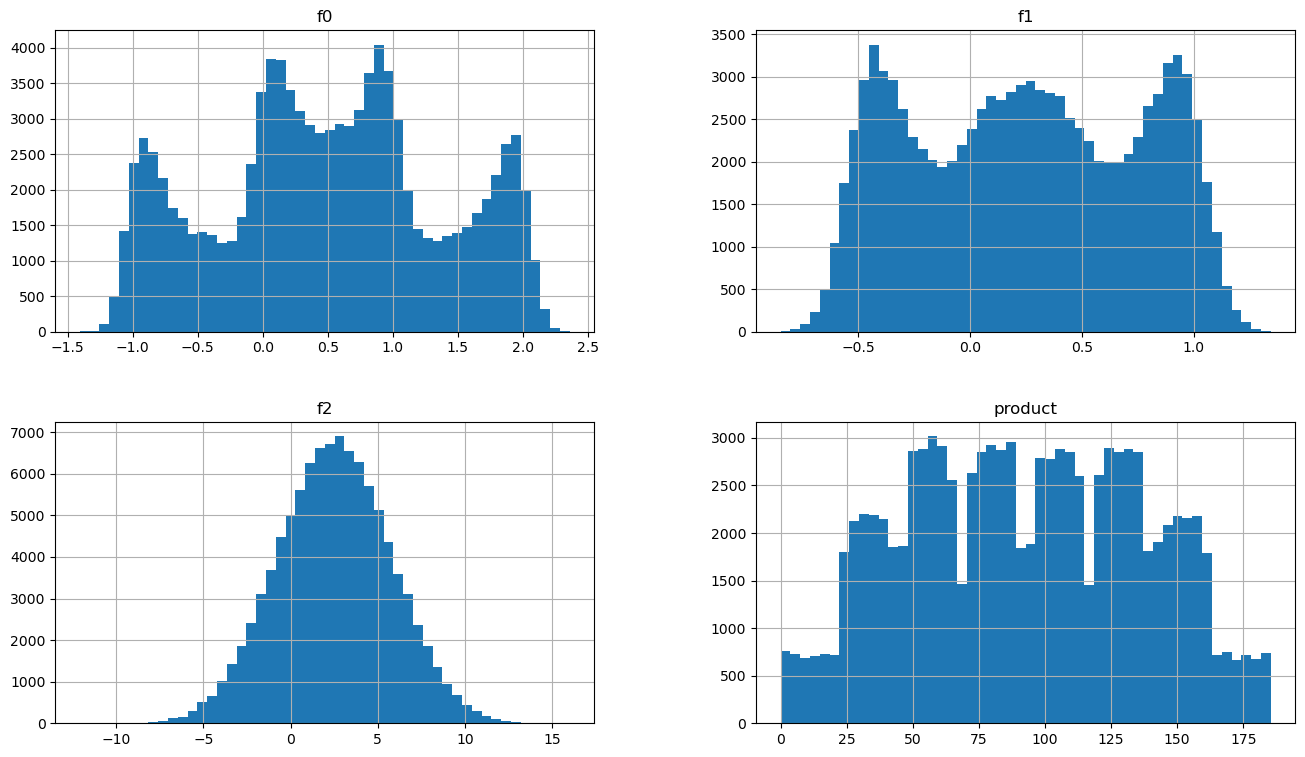

In [17]:
df_1.hist(figsize=(16, 9), bins=50)
display(df_1.describe())

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141040,-4.796625,2.494481,68.823409
std,8.965783,5.119897,1.703573,45.944494
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.152033,-4.813172,2.011470,57.085625
75%,8.620875,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


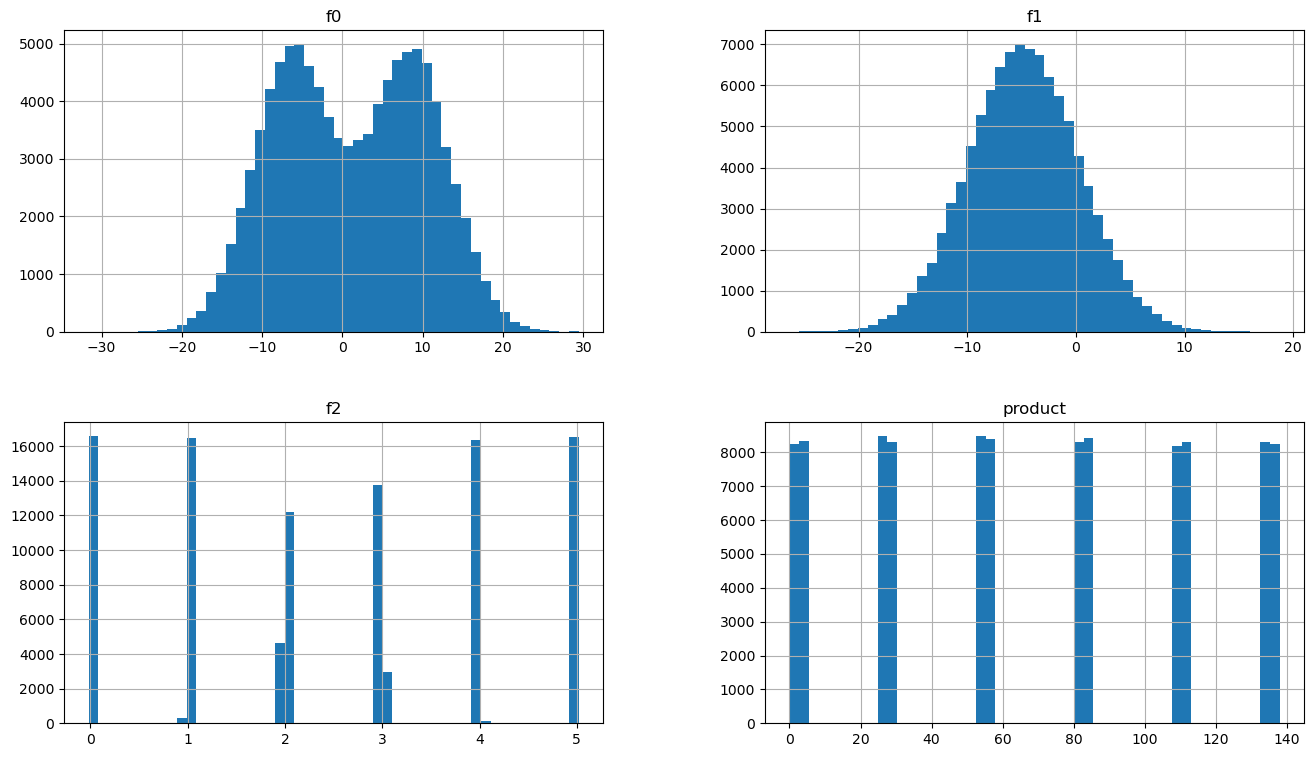

In [18]:
df_2.hist(figsize=(16, 9), bins=50)
display(df_2.describe())

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002010,-0.002100,2.495046,94.997431
std,1.732056,1.730390,3.473469,44.748717
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130269,59.450028
50%,0.009424,-0.009482,2.484188,94.917850
75%,1.158477,1.163592,4.858662,130.585544
max,7.238262,7.844801,16.739402,190.029838


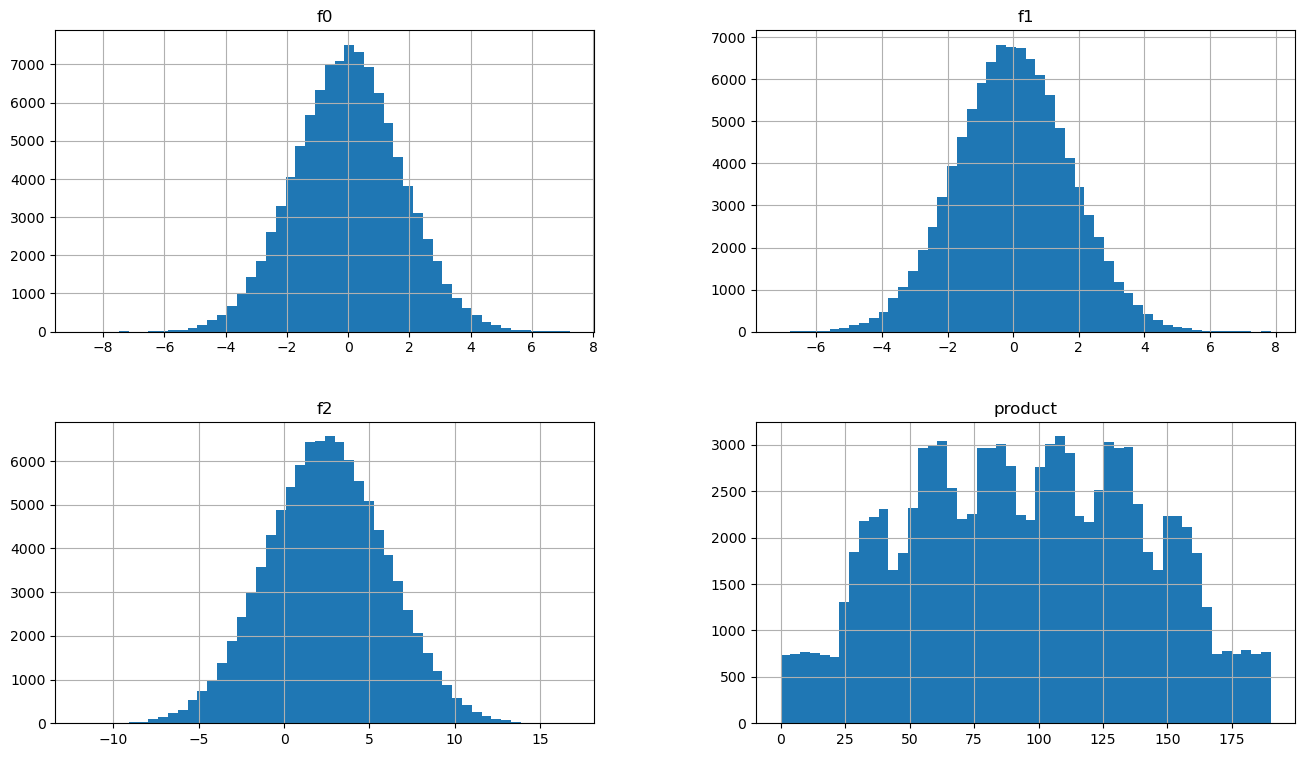

In [19]:
df_3.hist(figsize=(16, 9), bins=50)
display(df_3.describe())

**Наблюдения**

Во втором датафрейме значительно отличается форма распределения и средние значения столбца `product`.

### Итоги этапа
* Данные успешно загружены
* Пропуски и дубликаты не обнаружены
* Отмечены корреляции между признаками `product` и `f2`
* Отмечено необычное распределение значений признака `porduct` во втором датасете:
    * Самое низкое среднее значение запасов
    * Самое низкое максимальное значение запасов

## Обучение и проверка модели

### Подготовка выборок

In [20]:
# Список числовых признаков
numeric = ['f0', 'f1', 'f2']

Так как в данных наблюдается значительный разборс в значениях `f0`-`f2`, произведём разбиение вместе с масштабированием признаков.

### Обучение моделей
По условию задачи необходимо использовать **линейную регрессию**. Обучим 3 модели, сохраним предсказания и выведем на экран для каждой запас предсказанного сырья и RMSE:

In [21]:
# Глобальные списи для хранения валидационных и предсказанных ответов
y_valid_list = []
y_pred_valid_list = []

In [22]:
def split_and_train (dfs: list):
    
    # Очистка глобальных списков
    global y_valid_list
    y_valid_list = []
    global y_pred_valid_list
    y_pred_valid_list = []
    
    # Списки для искомых значений
    target_mean = []
    pred_mean = []
    rmse = []
    
    for ix, df in enumerate(dfs):
        
        # Атрибуты и целевой признак
        features = df.drop(['id','product'], axis=1)
        target = df['product']

        # Разбиение выборки на обучающую и валидационную в соотношении 75:25
        X_train, X_valid, y_train, y_valid = train_test_split(features,
                                                              target,
                                                              test_size = 0.25,
                                                              random_state=RND_ST)

        
        # Масштабирование числовых признаков
        scaler = StandardScaler()
        scaler.fit(X_valid.loc[:, numeric])
        X_train.loc[:, numeric] = scaler.transform(X_train.loc[:, numeric])
        X_valid.loc[:, numeric] = scaler.transform(X_valid.loc[:, numeric])

        # Тренировка модели
        model = LinearRegression()
        model.fit(X_train, y_train)
      
    
        ## V.2
        #y_pred_valid = model.predict(X_valid)
        
        # V.3
        # Согласование предсказанных значений по индексами с валидационной выборкой
        y_pred_valid = pd.Series(model.predict(X_valid), index=y_valid.index)
    
    
    
        # Сохранение валидационных и предсказанных ответов в глобальные списки
        # для взаимодействия с ними в следующих блоках исследования
        y_valid_list.append(y_valid)
        y_pred_valid_list.append(y_pred_valid)
        
        
        # Средний действительный запас
        target_mean.append(y_valid.mean())

        # Средний предсказанный запас
        pred_mean.append(y_pred_valid.mean())

        # RMSE на валидационной выборке 
        rmse.append(mean_squared_error(y_valid, y_pred_valid)**0.5 )
    
    # Объединение результатов в датафрейм
    res_df = pd.DataFrame({'Средний действительный запас сырья': target_mean,
                           'Средний предсказанный запас сырья': pred_mean,
                           'RMSE модели на валидационной выборке': rmse})
    
    # Сдвигаем индексы, чтобы согласовать нумерацию
    res_df.index = res_df.index + 1
    
    return res_df
    

In [23]:
# Расчёт средних значений и RMSE
split_and_train([df_1, df_2, df_3]).head().T

,1,2,3
Средний действительный запас сырья,92.721000,69.257784,94.960118
Средний предсказанный запас сырья,92.259673,69.252768,94.895236
RMSE модели на валидационной выборке,37.567267,0.888347,39.999376


### Итоги этапа
* Самые качественные предсказания получены с помощью второй модели со среднеквадратичной ошибкой меньше единицы
* Первая и третья модели показали RMSE одного порядка: 37,54—40,07. Это говорит о значительном снижении качества по сравнению со второй моделью.

## Подготовка к расчёту прибыли

Вычислим достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём со средним запасом в каждом регионе:

In [24]:
# Объём для безубыточной разработки
break_even = BUDGET / (BARREL_PRICE * ML_POINTS)
print(f"Достаточный объём сырья: {break_even:.2f} тыс. баррелей.")

data = [df_1, df_2, df_3]
for ix, data in enumerate(data):
    print(50*"-")
    
    print(f"\nРЕГИОН №{ix+1}\nСредний измеренный запас : {data['product'].mean():.2f} тыс. баррелей.")
    print(f"Средний предсказанный запас: {y_pred_valid_list[ix].mean():.2f} тыс. баррелей.")
    
    print(f"\nПроцент скважин с объёмом выше порога: {len(data.query('product > @break_even')) / len(data):.2%}")
    print(f"Количество скважин с объёмом выше порога: {len(data.query('product > @break_even'))}")

Достаточный объём сырья: 111.11 тыс. баррелей.
--------------------------------------------------

РЕГИОН №1
Средний измеренный запас : 92.50 тыс. баррелей.
Средний предсказанный запас: 92.26 тыс. баррелей.

Процент скважин с объёмом выше порога: 36.58%
Количество скважин с объёмом выше порога: 36578
--------------------------------------------------

РЕГИОН №2
Средний измеренный запас : 68.82 тыс. баррелей.
Средний предсказанный запас: 69.25 тыс. баррелей.

Процент скважин с объёмом выше порога: 16.54%
Количество скважин с объёмом выше порога: 16536
--------------------------------------------------

РЕГИОН №3
Средний измеренный запас : 95.00 тыс. баррелей.
Средний предсказанный запас: 94.90 тыс. баррелей.

Процент скважин с объёмом выше порога: 38.18%
Количество скважин с объёмом выше порога: 38174


### Итоги этапа
* Точка безубыточности составляет примерно 111 тыс. баррелей для каждой скважины
* Средний запас для каждого региона лежит в пределах 68-95 тыс. баррелей
* Количество скважин, в которых запас превышает пороговый, находится в пределах 16-38%

Для первого и третьего региона сохраняется достаточно высокая вероятность окупить вложения за счёт высокого процента скважин, объём которых превышает пороговый.

Так как среднее ожидаемое значение сырья по регионам рассчитано на основе всех точек, из которых мы можем разработать только 200, среди них могут оказать как скважины с высоким запасом продукта, так и с низким. 
    
   Чтобы лучше спрогнозировать прибыль и риски работы в регионе, необходимо использовать бутстрапирование — отбор точек случайным образом и расчёт прогноза по финансовым результата работы с ними.

## Функции для расчёта прибыли и рисков

**Калькулятор прибыли:**

In [25]:
def profit_calculation(target, probs, count):
    
    # Сортировка предсказаний для дальнейшего выбора лучших скважин
    probs_sorted = probs.sort_values(ascending=False)

    # Целевое значение объёма сырья
    # С помощью [:count] сохраняем только набор точек с максимальными значениями 
    product_vol = target[probs_sorted.index][:count].sum()
    
    # Прибыль в млн рублей
    net_profit = (product_vol * BARREL_PRICE - BUDGET)/1e6
    
    return net_profit

**Калькулятор рисков:**

In [26]:
def risk_calculation(y_valid, y_pred_valid):
    values = []

    # Bootstrap для 1000 сэмплов
    for i in range(1000):
        target_subsample = y_valid.sample(n=POINTS,
                                          replace=True,
                                          random_state=RND_ST) 
        
        # Цели которые предсказала модель для сампла
        probs_subsample = pd.Series(y_pred_valid)[target_subsample.index] 

        # Значения, полученние с помощью функции подсчета прибыли
        values.append(profit_calculation(target_subsample,
                                         probs_subsample,
                                         ML_POINTS)) 

    values = pd.Series(values)

    # Доверительный интервал 95% и среднее значение
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975) 
    mean = values.mean() 

    # Процент убытков
    outcome_risk = len(values[values < 0])/len(values)*100

    # Визуализация
    values.hist(bins=50)
    ax = plt.gca()
    ax.set_title("Распределение прибыли")
    ax.set_xlabel("Прибыль (млн руб)")
    ax.set_ylabel("Частота в выборке")
    ax.grid(True)
    plt.show()
    
    print(f"Средняя прибыль: {round(mean)} млн руб.")
    print(f"Q(0,975) прибыль: {round(upper)} млн руб.")
    print(f"Q(0,025) прибыль: {round(lower)} млн руб.")
    
    print(30*"-")
    print(f"Процент риска: {outcome_risk:.1f}%")

## Риски и прибыль для каждого региона


РЕГИОН №1


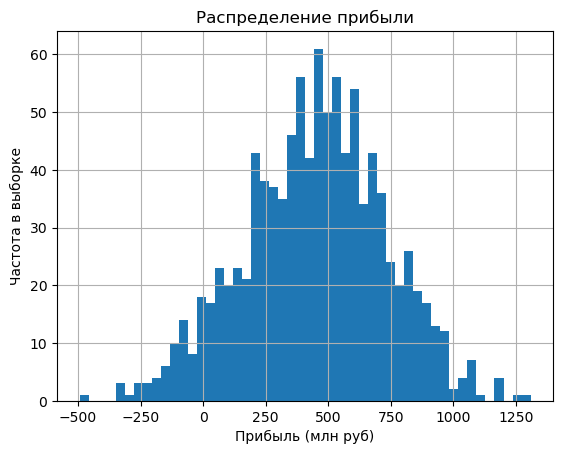

Средняя прибыль: 448 млн руб.
Q(0,975) прибыль: 960 млн руб.
Q(0,025) прибыль: -115 млн руб.
------------------------------
Процент риска: 6.6%

РЕГИОН №2


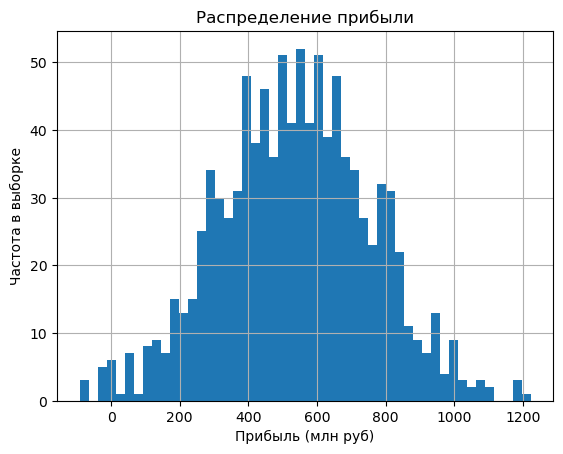

Средняя прибыль: 538 млн руб.
Q(0,975) прибыль: 964 млн руб.
Q(0,025) прибыль: 105 млн руб.
------------------------------
Процент риска: 0.9%

РЕГИОН №3


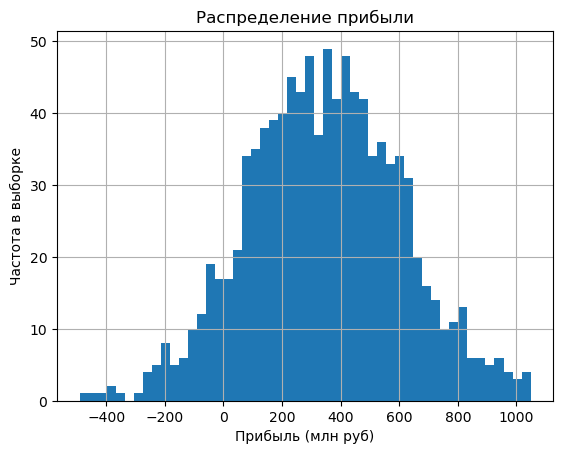

Средняя прибыль: 346 млн руб.
Q(0,975) прибыль: 871 млн руб.
Q(0,025) прибыль: -174 млн руб.
------------------------------
Процент риска: 9.1%


In [27]:
for i in range(3):
    print(f"\nРЕГИОН №{i+1}")
    risk_calculation(y_valid_list[i], y_pred_valid_list[i])

# Выводы 

* В ходе работы над проектом были обучены модели линейной регресси для каждого из 3-х регионов.
* Функции для расчёта прибыли и вероятности риска помогли обосновать решение о выборе наиболее перспективного региона для разработки.
---
Самым перспективным для разработки оказался **2-й регион** с прогнозируемой средней прибылью более 500 млн руб. и вероятностью риска около 1%.